In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Creating Engine
database_path="data/wildfires.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [3]:
# Query All Records in the the Database
data = pd.read_sql("SELECT * FROM wildfirecleaned", conn,parse_dates={'DISC_DATE': '%Y%m%d %H:%M:%S','CONTAIN_DATE':'%Y%m%d %H:%M:%S'})

In [4]:
data.head()

,UNIT_NAME,FIRE_YEAR,DISCOVERY_DOY,CAUSE_DESCR,CONT_DOY,FIRE_SIZE,FIRE_CLASS,LATITUDE,LONGITUDE,STATE,Shape,DISC_DATE,CONTAIN_DATE
0,Plumas National Forest,2005,33,Miscellaneous,33.0,0.10,A,40.036944,-121.005833,CA,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,2005-02-02,2005-02-02
1,Eldorado National Forest,2004,133,Lightning,133.0,0.25,A,38.933056,-120.404444,CA,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,2004-05-12,2004-05-12
2,Eldorado National Forest,2004,152,Debris Burning,152.0,0.10,A,38.984167,-120.735556,CA,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,2004-05-31,2004-05-31
3,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.913333,CA,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,2004-06-28,2004-07-03
4,Eldorado National Forest,2004,180,Lightning,185.0,0.10,A,38.559167,-119.933056,CA,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,2004-06-28,2004-07-03


In [5]:
data['TOTAL_DAYS']=data['CONTAIN_DATE']-data['DISC_DATE']

In [6]:
print(data.dtypes)

UNIT_NAME                 object
FIRE_YEAR                  int64
DISCOVERY_DOY              int64
CAUSE_DESCR               object
CONT_DOY                 float64
FIRE_SIZE                float64
FIRE_CLASS                object
LATITUDE                 float64
LONGITUDE                float64
STATE                     object
Shape                     object
DISC_DATE         datetime64[ns]
CONTAIN_DATE      datetime64[ns]
TOTAL_DAYS       timedelta64[ns]
dtype: object


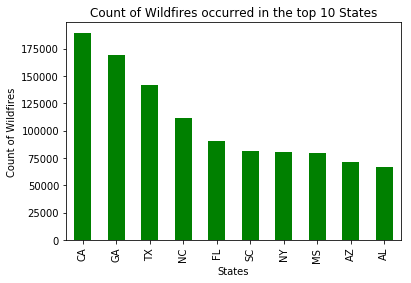

In [10]:
data['STATE'].value_counts().head(n=10).plot(kind='bar',color='green')
plt.title('Count of Wildfires occurred in the top 10 States')
plt.xlabel('States')
plt.ylabel('Count of Wildfires')
plt.show()

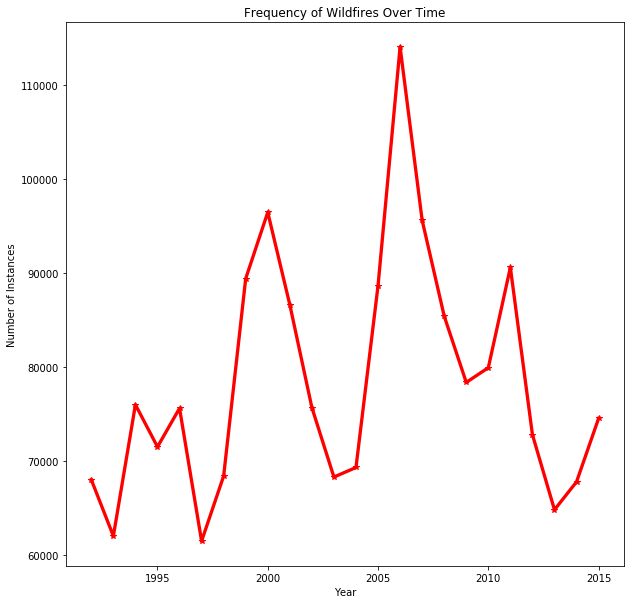

In [20]:
df_year = data[['FIRE_YEAR']]
df_year['FIRE_YEAR'].value_counts(sort=False).plot(kind="line",marker='*',figsize=(10,10), color='r', linewidth=3.3)
plt.title('Frequency of Wildfires Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Instances')
plt.show()

Text(0, 0.5, 'Count of Wildfires')

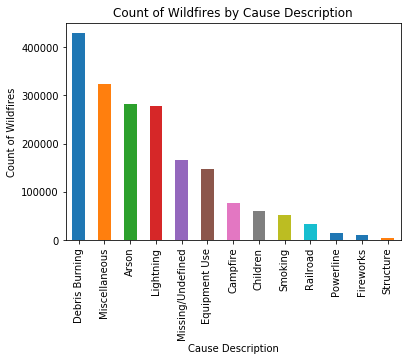

In [11]:
data["CAUSE_DESCR"].value_counts().plot(kind="bar")
plt.title('Count of Wildfires by Cause Description')
plt.xlabel('Cause Description')
plt.ylabel('Count of Wildfires')

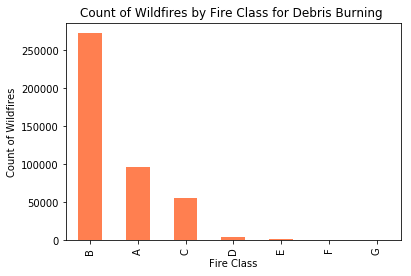

In [12]:
data_Burning = data[data['CAUSE_DESCR']=='Debris Burning']
data_Burning['FIRE_CLASS'].value_counts().plot(kind='bar',color='coral')
plt.title('Count of Wildfires by Fire Class for Debris Burning ')
plt.xlabel('Fire Class')
plt.ylabel('Count of Wildfires')
plt.show()

Text(0.5, 0, 'Fire Size (Hectares)')

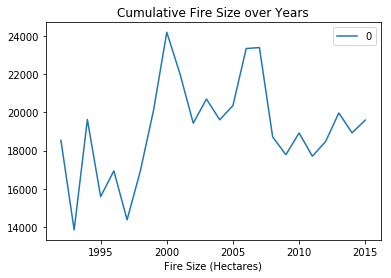

In [28]:
size_per_year=data.groupby(['FIRE_YEAR','FIRE_SIZE']).size().reset_index().groupby('FIRE_YEAR')[[0]].max()
plot_size=size_per_year.plot()
plot_size.set_title('Cumulative Fire Size over Years')
plot_size.set_xlabel("Fire Year")
plot_size.set_xlabel("Fire Size (Hectares)")